In [12]:
import matplotlib
import sys
sys.path.append('..')
from scipy import signal, stats, io
from neurolib.models.wc import WCModel
from neurolib.models import bold
from neurolib.utils import functions
from task_fc_simulation.onset_design_model import WCOnsetDesign
from task_fc_simulation.weight_matrix_utils import normalize, generate_modulars
from task_fc_simulation.read_utils import read_onsets_from_input, read_generate_task_matrices
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'Avenir'
matplotlib.rcParams['font.size'] = 16
plt.rcParams['image.cmap'] = 'plasma'
np.set_printoptions(suppress=True)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
def plot_bold_corr(wc_block, TR=2, inner_bold = False):
    num_tasks = len(wc_block.time_idxs_dict.keys())
    mean_bold_matrices = {}
    if inner_bold:
        BOLD = wc_block.wc.BOLD.BOLD
    else:
        BOLD = wc_block.BOLD
    
    for task_name in wc_block.time_idxs_dict.keys():
        bold_series = []
        for i in range(len(wc_block.time_idxs_dict[task_name])):
            idxs = wc_block.time_idxs_dict[task_name][i]
            idxs = [idx//TR for idx in idxs]
            if i==0:
                bold_series.append(BOLD[:,idxs[0]+8:idxs[1]])
            else:
                bold_series.append(BOLD[:,idxs[0]+3:idxs[1]])
        concat_bold = np.concatenate(bold_series, axis=1)
        mean_bold_matrices["FC_"+task_name] = np.corrcoef(concat_bold)
        
    fig, axs = plt.subplots(2, num_tasks, figsize = (12,8))
    C_list = list(mean_bold_matrices.values())
    #title_list =list(mean_bold_matrices.keys())
    #title_list1 = [title+ "-Rest" for title in title_list]
    for i, (title, C) in enumerate(mean_bold_matrices.items()):
        axs[0, i].imshow(C); axs[0,i].set_title(title);
        axs[1, i].imshow(C - mean_bold_matrices["FC_Rest"]); axs[0,i].set_title(title+"-Rest");
    fig.suptitle("Mean block FC matrices");    
    return mean_bold_matrices

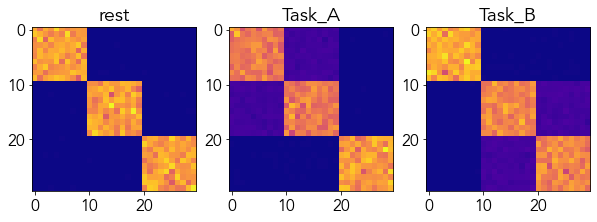

In [14]:
mat_path = '../data/SOTs_new.mat'
num_regions=30
D = np.ones((num_regions,num_regions))*250
C_rest, C_task_dict  = read_generate_task_matrices(mat_path, num_regions, num_modules = 3, 
                                sigma = 0.1, norm_type = "cols")

C_task_list = list(C_task_dict.values())
C_list = [C_rest]+C_task_list
title_list =['rest']+ list(C_task_dict.keys())
fig, axs = plt.subplots(1, 3, figsize = (10,4))

for i in [0,1,2]:
    axs[i].imshow(C_list[i]); axs[i].set_title(title_list[i]);

## Block design

Здесь для 30 нодов - но это можно прямо внутри поменять, пока проверяем что работает,  чтобы побыстрее считалось
Коэффициенты из которых формируются синаптические матрицы тоже можно менять
Была задача:
 - rest  = 15 секунд
 - 7 блоков Task A = 7*30 = 210s
 - 7 блоков Task B = 7*30 = 210s

но тут должно быть все кратно двум, поэтому:

     - rest  = 16 секунд
     - 7 блоков Task A = 7*32 = 210s
     - 7 блоков Task B = 7*32 = 210s
     - rest  = 16 секунд

In [25]:
#в каждом блоке два таска разделенных рестом
n_blocks = 2
task_names_list = []
for i in range(n_blocks):
    task_names_list.extend(["Task_A", "Task_B"])
onset_time_list = [16+(32+16)*k for k in range(n_blocks*2)]
duration_list =2*n_blocks*[32]

CPU times: user 13.1 s, sys: 238 ms, total: 13.3 s
Wall time: 13.3 s


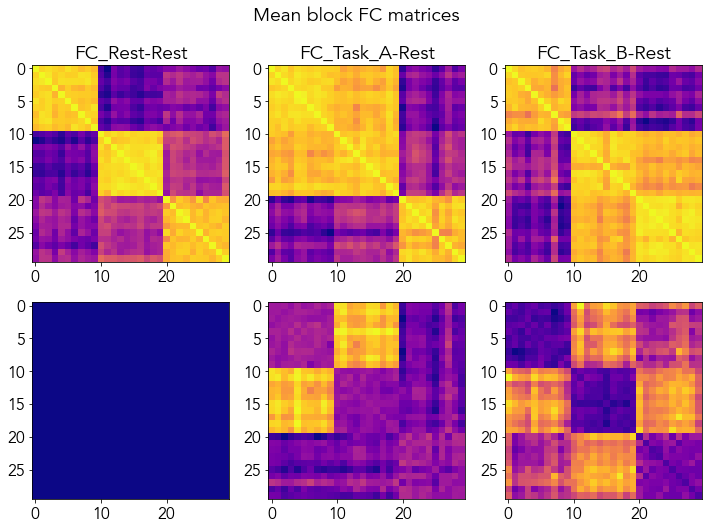

In [26]:
%%time
wc_block = WCOnsetDesign(C_task_dict, C_rest, D, rest_before=False,
                                 onset_time_list=onset_time_list, duration_list=duration_list, 
                                 task_name_list=task_names_list,
                                 last_duration=16, append_outputs=False, bold=True)
wc_block.generate_full_series()
mean_bold_matrices = plot_bold_corr(wc_block, TR=2, inner_bold = True)

In [30]:
wc_block.wc.BOLD.BOLD

array([[0.        , 0.05678858, 0.06207307, ..., 0.06219484, 0.06217639,
        0.06219148],
       [0.        , 0.05691962, 0.06207869, ..., 0.06219423, 0.06219393,
        0.06220453],
       [0.        , 0.05688145, 0.06208041, ..., 0.06220692, 0.06219911,
        0.06221276],
       ...,
       [0.        , 0.05677724, 0.06207248, ..., 0.06219127, 0.06222257,
        0.0622277 ],
       [0.        , 0.05662009, 0.0620653 , ..., 0.06217376, 0.06222017,
        0.06223121],
       [0.        , 0.05658123, 0.06205047, ..., 0.06216044, 0.06221249,
        0.06220335]])

In [31]:
np.save(f"../results/test.npy", wc_block.wc.BOLD.BOLD, allow_pickle = True)
np.load(f"../results/test.npy")

array([[0.        , 0.05678858, 0.06207307, ..., 0.06219484, 0.06217639,
        0.06219148],
       [0.        , 0.05691962, 0.06207869, ..., 0.06219423, 0.06219393,
        0.06220453],
       [0.        , 0.05688145, 0.06208041, ..., 0.06220692, 0.06219911,
        0.06221276],
       ...,
       [0.        , 0.05677724, 0.06207248, ..., 0.06219127, 0.06222257,
        0.0622277 ],
       [0.        , 0.05662009, 0.0620653 , ..., 0.06217376, 0.06222017,
        0.06223121],
       [0.        , 0.05658123, 0.06205047, ..., 0.06216044, 0.06221249,
        0.06220335]])

In [39]:
n_blocks = 7
task_names_list = []
for i in range(n_blocks):
    task_names_list.extend(["Task_A", "Task_B"])
onset_time_list = [16+(32+16)*k for k in range(n_blocks*2)]
duration_list =2*n_blocks*[32]

In [40]:
onset_time_list

[16, 64, 112, 160, 208, 256, 304, 352, 400, 448, 496, 544, 592, 640]

In [41]:
%%time
for i in tqdm(range(6)):
    wc_block = WCOnsetDesign(C_task_dict, C_rest, D, rest_before=False,
                                 onset_time_list=onset_time_list, duration_list=duration_list, 
                                 task_name_list=task_names_list,
                                 last_duration=16, append_outputs=False, bold=True)
    wc_block.generate_full_series()
    np.save(f"../results/Block30Bold_{i}.npy", wc_block.wc.BOLD.BOLD)

100%|█████████████████████████████████████████████| 6/6 [04:33<00:00, 45.51s/it]

CPU times: user 4min 27s, sys: 4.85 s, total: 4min 32s
Wall time: 4min 33s


In [42]:
wc_block.wc.BOLD.BOLD.T.shape

(344, 30)

In [43]:
input_data = io.loadmat(mat_path)
num_sub = 6
BOLD_subj = np.zeros((*wc_block.wc.BOLD.BOLD.T.shape,6))
for i in range(6):
    BOLD_subj[:,:,i] = np.load(f"../results/Block30Bold_{i}.npy").T
input_data['BOLD'] =  BOLD_subj
io.savemat("../data/SOTsBOLD_Block.mat", input_data)    

## Считаем болд отдельно и меняем TR
сделала для примера всего два блока

In [6]:
#в каждом блоке два таска разделенных рестом
n_blocks = 3
task_names_list = []
for i in range(n_blocks):
    task_names_list.extend(["Task_A", "Task_B"])
onset_time_list = [16+(32+16)*k for k in range(n_blocks*2)]
duration_list =2*n_blocks*[32]

CPU times: user 22.8 s, sys: 3.59 s, total: 26.4 s
Wall time: 26.5 s


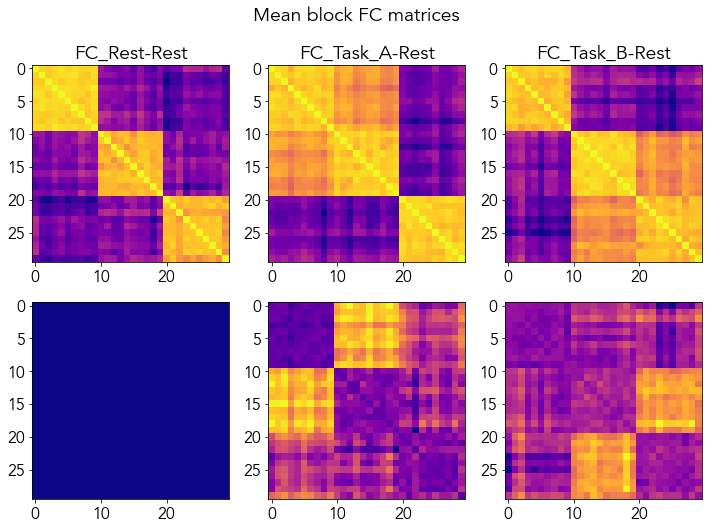

In [7]:
%%time
wc_block = WCOnsetDesign(C_task_dict, C_rest, D, rest_before=False,
                                 onset_time_list=onset_time_list, duration_list=duration_list, 
                                 task_name_list=task_names_list,
                                 last_duration=16, append_outputs=True, bold=False)
wc_block.generate_full_series()
#здесь говорим надо ли сразу выкинуть начало из болда, из нейрональной ничего не выкидывается
wc_block.generate_bold(TR=2, drop_first=0, clear_exc=False)
mean_bold_matrices = plot_bold_corr(wc_block, TR=2, inner_bold = False)

In [8]:
#тут живет нейрональная активность
wc_block.wc.exc.shape

(30, 3040000)

с болдом надо сворачивать отдельно, не успела доделать вывод графики потом

In [2]:
np.random.seed(17)
np.random.randn(10)

array([ 0.27626589, -1.85462808,  0.62390111,  1.14531129,  1.03719047,
        1.88663893, -0.11169829, -0.36210134,  0.14867505, -0.43778315])

In [11]:
np.random.seed(17)
np.random.randn(10)

array([ 0.27626589, -1.85462808,  0.62390111,  1.14531129,  1.03719047,
        1.88663893, -0.11169829, -0.36210134,  0.14867505, -0.43778315])